In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
rdkit is already installed


In [10]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-e8m5nnpe
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-e8m5nnpe
  Created wheel for mol2vec: filename=mol2vec-0.1-cp36-none-any.whl size=14026 sha256=0eeb70a0f5efb792496fdd509bfc9879a6dda809f5747274ad1c4732a56634a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kw33soej/wheels/96/0f/2d/a1092b9677c96453dc244b209544cac61bc8b974cbffb50063
Successfully built mol2vec


In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test, actual_test):
    prediction = model.predict(X_test)
    df_pred = pd.DataFrame(data = [[x,y] for x,y in zip(actual_test, prediction)], columns=["SMILES sequence","Binding Affinity"])
    #df_pred["Binding Affinity"] = prediction
    df_pred.to_csv("./submission.csv", sep=',',index=False)
    print(np.shape(X_test), np.shape(prediction))
    '''
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction, squared=False)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('logP')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))
    '''

In [5]:
df= pd.read_csv('/content/drive/My Drive/SMAI/Assignment-4/q3/q3_train.csv')
print(df.head())
#target = df['Binding Affinity']
#df.drop(columns='Binding Affinity',inplace=True)

           SMILES sequence  Binding Affinity
0     CCNC(C)C(NC)c1ccccc1          -18.0861
1         CONC(=O)c1cncnc1          -17.5783
2    CCNC1CCCN(Cc2ccsc2)C1          -20.3645
3  CC(NC(=O)CSCCN)c1ccccc1          -19.3144
4     CCC(CS)CN(C)c1ccccc1          -15.8451


In [6]:
from rdkit import Chem 
df['mol'] = df['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x)) 
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)
df.head()

,SMILES sequence,Binding Affinity,mol,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
0,CCNC(C)C(NC)c1ccccc1,-18.0861,<rdkit.Chem.rdchem.Mol object at 0x7f6240dc9cb0>,34,14,12,0,2,0
1,CONC(=O)c1cncnc1,-17.5783,<rdkit.Chem.rdchem.Mol object at 0x7f6240dc9e40>,18,11,6,2,3,0
2,CCNC1CCCN(Cc2ccsc2)C1,-20.3645,<rdkit.Chem.rdchem.Mol object at 0x7f623b861580>,35,15,12,0,2,0
3,CC(NC(=O)CSCCN)c1ccccc1,-19.3144,<rdkit.Chem.rdchem.Mol object at 0x7f623b8613a0>,34,16,12,1,2,0
4,CCC(CS)CN(C)c1ccccc1,-15.8451,<rdkit.Chem.rdchem.Mol object at 0x7f623b861620>,33,14,12,0,1,0


In [0]:
from rdkit.Chem import Descriptors

df['tpsa'] = df['mol'].apply(lambda x: Descriptors.TPSA(x))
df['mol_w'] = df['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df['num_valence_electrons'] = df['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df['num_heteroatoms'] = df['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [8]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

#Leave only features columns
train_df = df.drop(columns=['SMILES sequence', 'Binding Affinity', 'mol'])
y = df['Binding Affinity'].values

print(train_df.columns)

#Perform a train-test split. We'll use 10% of the data to evaluate the model while training on 90%

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=.2, random_state=1)

Index(['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms',
       'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'tpsa', 'mol_w',
       'num_valence_electrons', 'num_heteroatoms'],
      dtype='object')


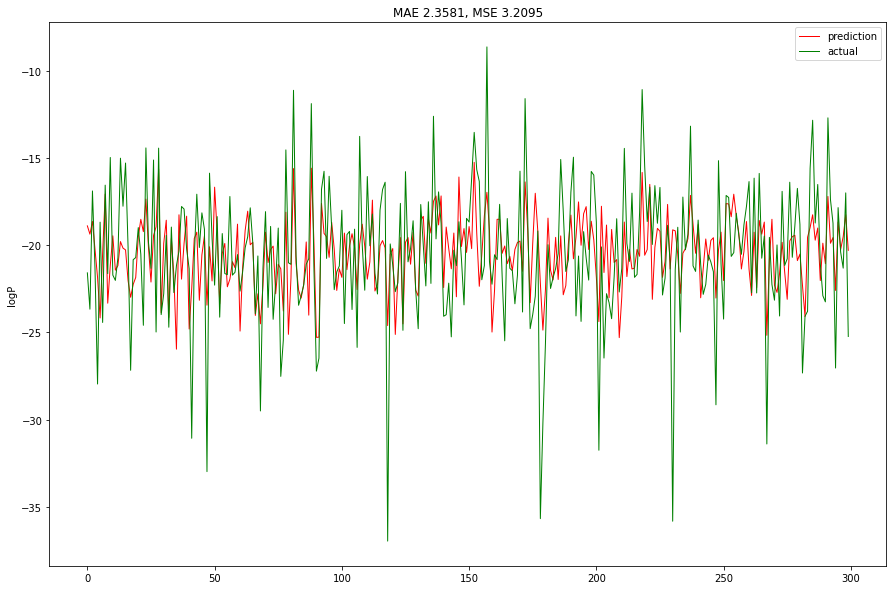

MAE score: 2.3581
MSE score: 3.2095


In [37]:
#Train the model
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
#Evaluate results
evaluation(ridge, X_test, y_test)

In [48]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('/content/drive/My Drive/SMAI/Assignment-4/q3/model_300dim.pkl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [49]:
from rdkit import Chem 

mdf= pd.read_csv('/content/drive/My Drive/SMAI/Assignment-4/q3/q3_train.csv')
test_mdf = pd.read_csv('/content/drive/My Drive/SMAI/Assignment-4/q3/q3_test.csv')
print(mdf.head())
target = mdf['Binding Affinity']
mdf.drop(columns='Binding Affinity',inplace=True)
#Transforming SMILES to MOL
mdf['mol'] = mdf['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x))
test_mdf['mol'] = test_mdf['SMILES sequence'].apply(lambda x: Chem.MolFromSmiles(x))

           SMILES sequence  Binding Affinity
0     CCNC(C)C(NC)c1ccccc1          -18.0861
1         CONC(=O)c1cncnc1          -17.5783
2    CCNC1CCCN(Cc2ccsc2)C1          -20.3645
3  CC(NC(=O)CSCCN)c1ccccc1          -19.3144
4     CCC(CS)CN(C)c1ccccc1          -15.8451


In [50]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
print('Molecular sentence:', mol2alt_sentence(mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(mdf['mol'][1], radius=1)), model, unseen='UNK')))

print('Molecular sentence:', mol2alt_sentence(test_mdf['mol'][1], radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(test_mdf['mol'][1], radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(test_mdf['mol'][1], radius=1)), model, unseen='UNK')))

Molecular sentence: ['2246728737', '3975275337', '864674487', '903112553', '847961216', '2204949651', '2246699815', '1054767590', '864942730', '1510328189', '3217380708', '2994748777', '3218693969', '3777168895', '2041434490', '3118255683', '3218693969', '725322217', '2041434490', '3118255683', '3218693969', '3777168895']

MolSentence object: MolSentence with 22 words

DfVec object: (22, 300) dimensional vector
Molecular sentence: ['2246728737', '3542456614', '2245384272', '3994088662', '864674487', '2814583100', '2245273601', '602889953', '2245384272', '4022716898', '864662311', '1535166686', '3217380708', '3579962709', '3218693969', '951226070', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '98513984', '3218693969', '951226070']

MolSentence object: MolSentence with 24 words

DfVec object: (24, 300) dimensional vector


In [51]:
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values

print(X.shape)

test_mdf['sentence'] = test_mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
test_mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(test_mdf['sentence'], model, unseen='UNK')]
Y = np.array([x.vec for x in test_mdf['mol2vec']])
print(Y.shape)

(9000, 300)
(2500, 300)


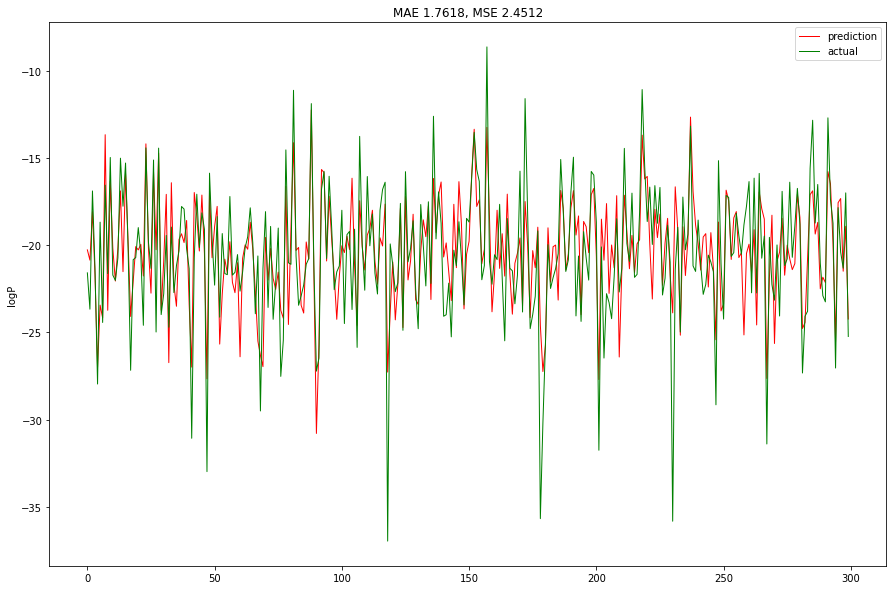

MAE score: 1.7618
MSE score: 2.4512


In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
ridge = RidgeCV(cv=10, normalize=False)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test, test_mdf['SMILES sequence'])

In [52]:
from sklearn.svm import SVR
svr_clf = SVR(C=25.0,epsilon=1.3, gamma=0.0007)
print(svr_clf.get_params())
#svr_clf.fit(X_train, y_train)
#evaluation(svr_clf, X_test, y_test, X_test[:,0]) #test_mdf['SMILES sequence'])
svr_clf.fit(X, y)
evaluation(svr_clf, Y, y_test, test_mdf['SMILES sequence'])

{'C': 25.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 1.3, 'gamma': 0.0007, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
(2500, 300) (2500,)


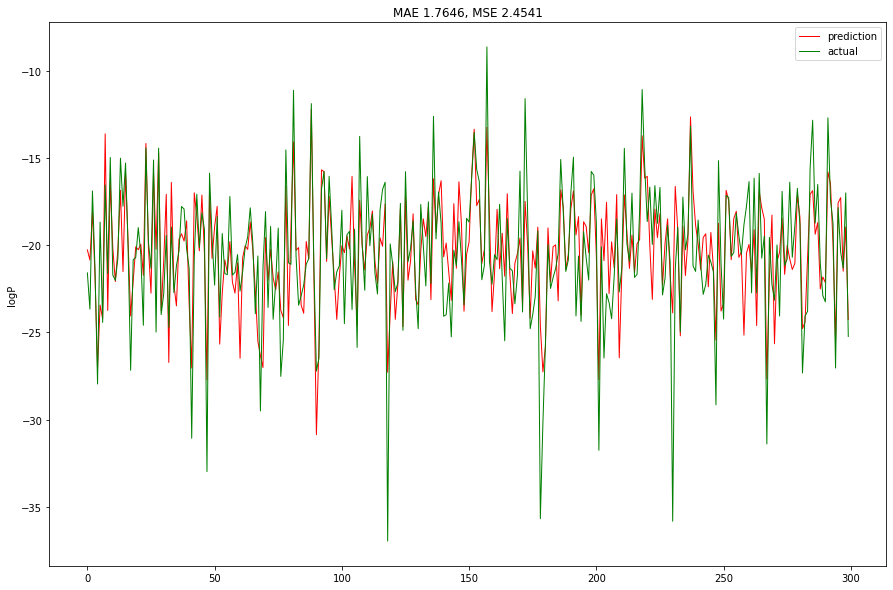

MAE score: 1.7646
MSE score: 2.4541


In [55]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression(normalize=False).fit(X_train, y_train)
evaluation(lr_clf, X_test, y_test)